[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MokryYezhik/studying-CNN/blob/master/%5Bhw%5Ddense_and_convolutional_nn.ipynb)

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

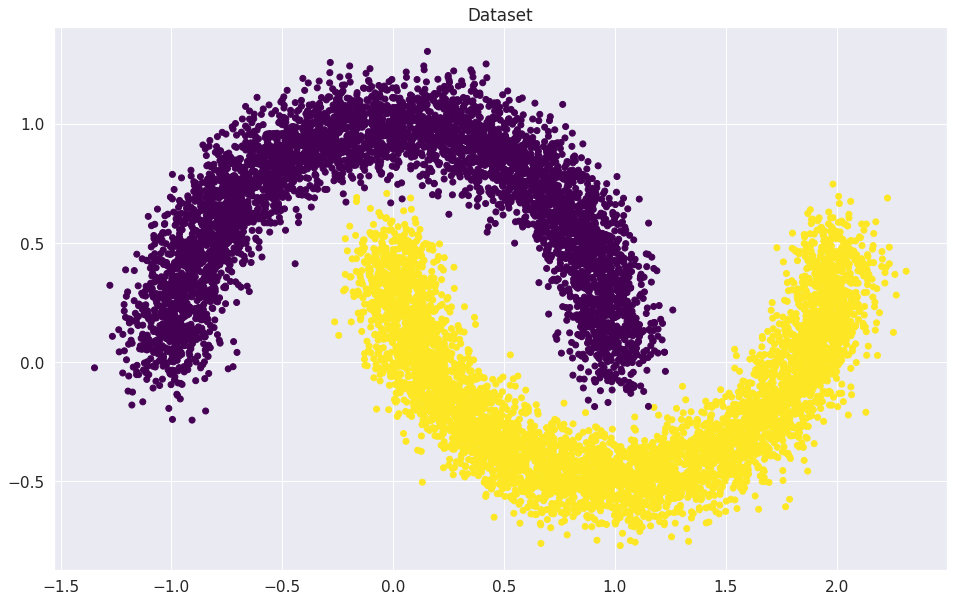

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.tensor(X_train, dtype = torch.float32)
y_train_t =  torch.tensor(y_train, dtype = torch.float32)
X_val_t =  torch.tensor(X_val, dtype = torch.float32)
y_val_t = torch.tensor(y_val, dtype = torch.float32)

In [ ]:
X_train_t.shape, y_train_t.shape, X_val_t.shape, y_val_t.shape

(torch.Size([7500, 2]),
 torch.Size([7500]),
 torch.Size([2500, 2]),
 torch.Size([2500]))

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            #self.bias_term = # YOUR CODE GOES HERE
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        #x =  # YOUR CODE GOES HERE
        x = x @ self.weights.T
        if self.bias:
            #x +=  # YOUR CODE GOES HERE
            x += self.bias_term
        return x.flatten()

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
#YOUR CODE
list_of_params = list(linear_regression.parameters())
list_of_params

[Parameter containing:
 tensor([[2.6575, 1.8143]], requires_grad=True), Parameter containing:
 tensor([-0.1405], requires_grad=True)]

In [ ]:
# сравнение с моделум Linear
list(nn.Linear(in_features=2, out_features=1).parameters())

[Parameter containing:
 tensor([[0.3730, 0.0034]], requires_grad=True), Parameter containing:
 tensor([0.3055], requires_grad=True)]

In [ ]:
print('Количество параметров: ')
list_of_params[0].shape[1] + list_of_params[1].shape[0]

Количество параметров: 


3

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(linear_regression, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1]                       3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

 параметрами данной модели линейного слоя являются 2 коэффициента (w) и одно смещение (b)

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #outp =  # YOUR CODE. Use linear_regression to get outputs
        outp = linear_regression(X_batch)
        #loss =  # YOUR CODE. Compute loss
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        #probabilities =  # YOUR CODE. Compute probabilities
        probabilities = linear_regression(X_batch)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.703125
Iteration: 100
Batch accuracy: 0.7890625
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.859375
Iteration: 400
Batch accuracy: 0.8515625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.875

Iteration: 637.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 637

### Визуализируем результаты

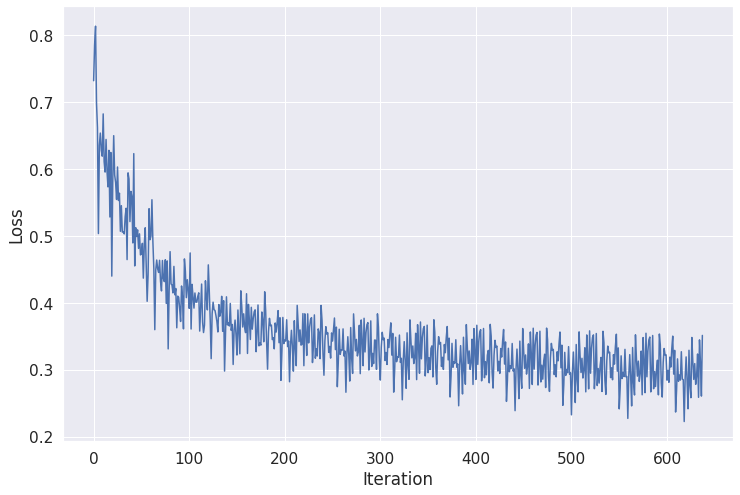

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

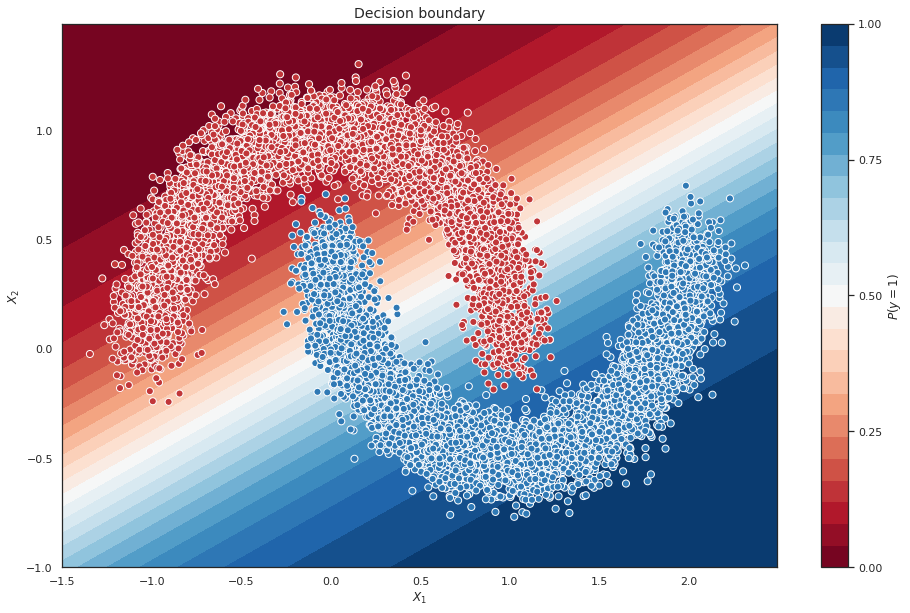

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        #preds = #YOUR CODE. Compute predictions
        probs = linear_regression(x_batch)
        preds = (probs > 0.5).type(torch.float32)
        predictions = np.hstack((predictions, preds.numpy().flatten())) #объединение предиктов по всем бачам
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.8696

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** ~0.87

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)
print(f'train size: {len(train_dataset)}')
print(f'val size: {len(val_dataset)}')

#train_dataloader =  # YOUR CODE GOES HERE
train_dataloader = DataLoader(train_dataset, batch_size=128)
#valid_dataloader =  # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

train size: 60000
val size: 10000


In [ ]:
it = iter(train_dataloader)

In [ ]:
X, y = next(it)

In [ ]:
y

tensor([7, 2, 8, 7, 6, 9, 2, 2, 3, 8, 1, 6, 5, 1, 1, 0, 2, 6, 4, 5, 8, 3, 1, 5,
        1, 9, 2, 7, 4, 4, 4, 8, 1, 5, 8, 9, 5, 6, 7, 9, 9, 3, 7, 0, 9, 0, 6, 6,
        2, 3, 9, 0, 7, 5, 4, 8, 0, 9, 4, 1, 2, 8, 7, 1, 2, 6, 1, 0, 3, 0, 1, 1,
        8, 2, 0, 3, 9, 4, 0, 5, 0, 6, 1, 7, 7, 8, 1, 9, 2, 0, 5, 1, 2, 2, 7, 3,
        5, 4, 9, 7, 1, 8, 3, 9, 6, 0, 3, 1, 1, 2, 6, 3, 5, 7, 6, 8, 3, 9, 5, 8,
        5, 7, 6, 1, 1, 3, 1, 7])

In [ ]:
for i, (X, y) in enumerate(train_dataloader):
    print(i)
    print(y)

0
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])
1
tensor([1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6,
        1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
        9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8, 3, 2,
        1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6, 4, 7,
        1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7, 5, 8, 0, 9,
        1, 0, 3, 1, 2, 2, 3, 3])
2
tensor([6, 4, 7, 5, 0, 6, 2, 7, 9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3,
        9, 3, 9, 0, 5, 9, 6, 5, 7, 4, 1, 3, 4, 0

In [ ]:
468*128

59904

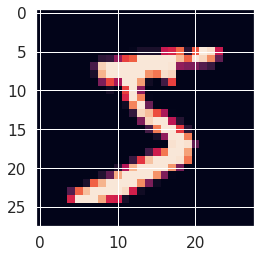

In [ ]:
print(plt.imshow(train_dataloader.dataset.data[0].numpy());

In [ ]:
print('размер картинок:')
train_dataloader.dataset.data[0].shape

размер картинок:


torch.Size([28, 28])

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(28*28, 128), #входной слой 28*28 нейронов -> 1-й скрытый слой 128 нейронов
    activation(),
    nn.Linear(128, 128), # 1-й скрытый слой 128 нейронов -> 2-й скрытый слой 128 нейронов
    activation(),
    nn.Linear(128, 10), # 2-й скрытый слой 128 нейронов -> выходной слой 10 нейронов
)

In [ ]:
#criterion = #YOUR CODE. Select a loss function
criterion = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device: ', device)

device:  cuda


In [ ]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1) # предсказанный класс - индекс с макс-й вероятностью, т.к. классы - это 0,2,3...9, то индекс и есть класс
            #correct =  # YOUR CODE GOES HERE# количество правильно предсказанных классов
            correct = torch.sum(preds == y_batch) # количество правильно предсказанных классов
            #all =  # YOUR CODE GOES HERE
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8786333333333334
Loader: valid. Accuracy: 0.9227
Epoch: 2
Loader: train. Accuracy: 0.9418333333333333
Loader: valid. Accuracy: 0.9445
Epoch: 3
Loader: train. Accuracy: 0.9597166666666667
Loader: valid. Accuracy: 0.958
Epoch: 4
Loader: train. Accuracy: 0.9686166666666667
Loader: valid. Accuracy: 0.9642
Epoch: 5
Loader: train. Accuracy: 0.9744666666666667
Loader: valid. Accuracy: 0.9658
Epoch: 6
Loader: train. Accuracy: 0.9786333333333334
Loader: valid. Accuracy: 0.9682
Epoch: 7
Loader: train. Accuracy: 0.9817666666666667
Loader: valid. Accuracy: 0.9631
Epoch: 8
Loader: train. Accuracy: 0.98395
Loader: valid. Accuracy: 0.966
Epoch: 9
Loader: train. Accuracy: 0.98515
Loader: valid. Accuracy: 0.9688
Epoch: 10
Loader: train. Accuracy: 0.9861833333333333
Loader: valid. Accuracy: 0.9698


In [ ]:
print(torch.tensor([ 0,  2,  0,  1]) == torch.tensor([ 0,  2,  0,  0]))
print(torch.sum(torch.tensor([ 0,  2,  0,  1]) == torch.tensor([ 0,  2,  0,  0])))
print(torch.sum(torch.tensor([ 0,  2,  0,  1]) == torch.tensor([ 0,  2,  0,  0])).item())

tensor([ True,  True,  True, False])
tensor(3)
3


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9227, 0.9445, 0.958, 0.9642, 0.9658, 0.9682, 0.9631, 0.966, 0.9688, 0.9698]

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    #YOUR CODE
    model = nn.Sequential(
        nn.Flatten(),
        #YOUR CODE. Add layers to your sequential class
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128) ,
        activation(),
        nn.Linear(128, 10),
    )
    optimizer = torch.optim.Adam(model.parameters())

    model.to(device)

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = torch.sum(preds == y_batch)
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    
    return accuracy["valid"]

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [ ]:
print('линейная функция активациии')
plain_accuracy = test_activation_function(Identical)
#relu_accuracy = #YOUR CODE
print('функция активациии ReLU')
relu_accuracy = test_activation_function(nn.ReLU)
#leaky_relu_accuracy = #YOUR CODE
print('функция активациии LeakyReLU')
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

линейная функция активациии
Epoch: 1
Loader: train. Accuracy: 0.8635
Loader: valid. Accuracy: 0.8817
Epoch: 2
Loader: train. Accuracy: 0.8950166666666667
Loader: valid. Accuracy: 0.9005
Epoch: 3
Loader: train. Accuracy: 0.9004166666666666
Loader: valid. Accuracy: 0.901
Epoch: 4
Loader: train. Accuracy: 0.9023333333333333
Loader: valid. Accuracy: 0.902
Epoch: 5
Loader: train. Accuracy: 0.90415
Loader: valid. Accuracy: 0.9025
Epoch: 6
Loader: train. Accuracy: 0.9051166666666667
Loader: valid. Accuracy: 0.9015
Epoch: 7
Loader: train. Accuracy: 0.9063833333333333
Loader: valid. Accuracy: 0.9015
Epoch: 8
Loader: train. Accuracy: 0.9073833333333333
Loader: valid. Accuracy: 0.9017
Epoch: 9
Loader: train. Accuracy: 0.9085666666666666
Loader: valid. Accuracy: 0.9017
Epoch: 10
Loader: train. Accuracy: 0.9099666666666667
Loader: valid. Accuracy: 0.9034
функция активациии ReLU
Epoch: 1
Loader: train. Accuracy: 0.86395
Loader: valid. Accuracy: 0.9189
Epoch: 2
Loader: train. Accuracy: 0.930083333333

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

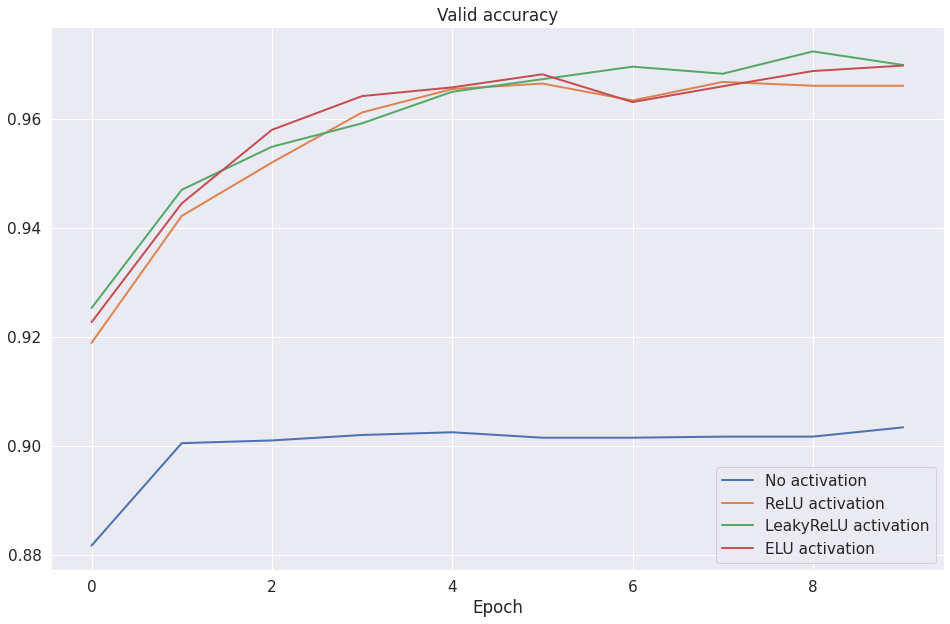

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

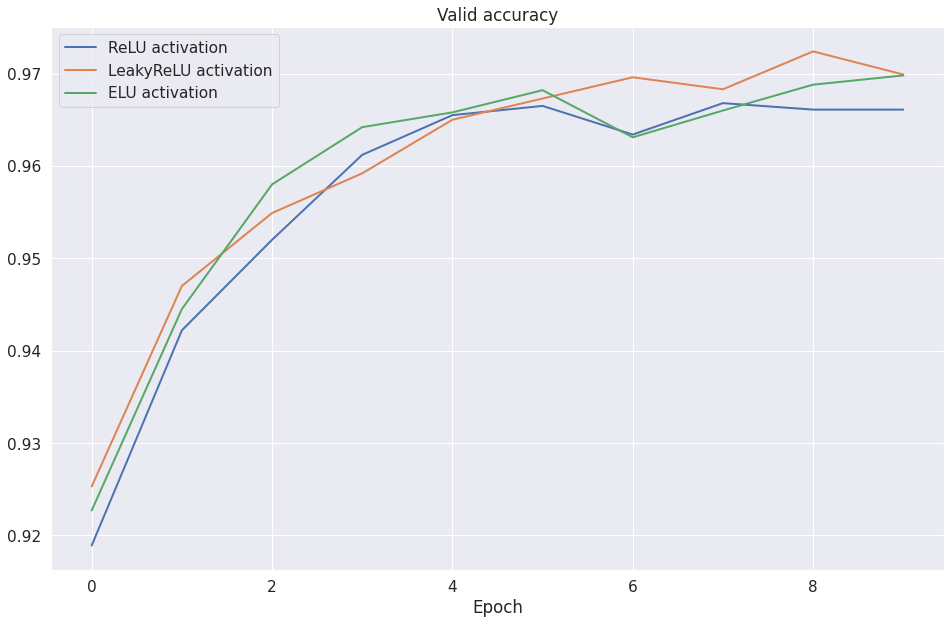

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** 

в данном запуске это была leaky ReLU. но вообще все три примерно одинаковые результаты могут выдавать от запуска к запуску


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-03-26 15:51:32--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-03-26 15:51:32--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   220KB/s    in 0.2s    

2022-03-26 15:51:33 (220 KB/s) - ‘sample_photo.jpg’ saved [49337/4

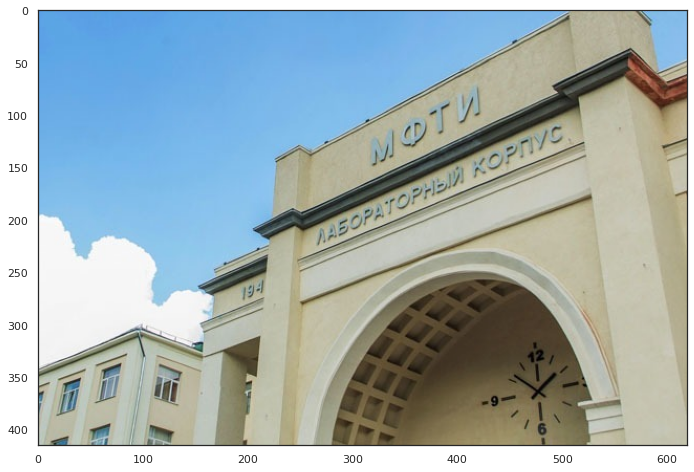

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
filters = [
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]],

    [[0, 1, 0],
     [0, -2, 0],
     [0, 1, 0]],

    [[0, 0, 0],
     [1, -2, 1],
     [0, 0, 0]],

    [[0, 1, 0],
     [1, -4, 1],
     [0, 1, 0]],

    [[0, -1, 0],
     [-1, 5, -1],
     [0, -1, 0]],

    [[0.0625, 0.125, 0.0625],
     [0.125, 0.25, 0.125],
     [0.0625, 0.125, 0.0625]]
]

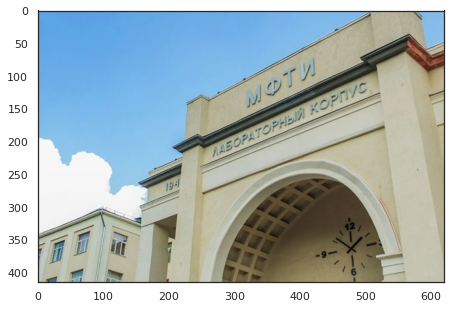


[[0 0 0]
 [0 1 0]
 [0 0 0]]



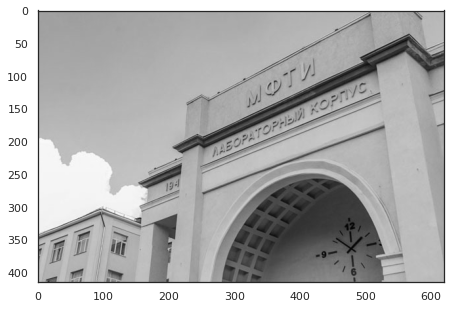

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[[ 0  1  0]
 [ 0 -2  0]
 [ 0  1  0]]



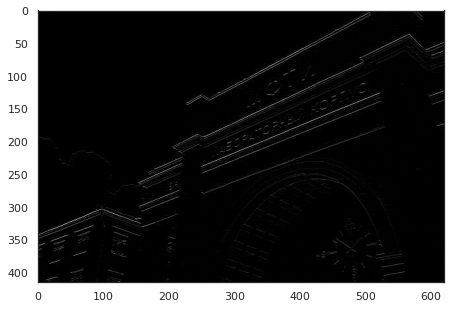

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[[ 0  0  0]
 [ 1 -2  1]
 [ 0  0  0]]



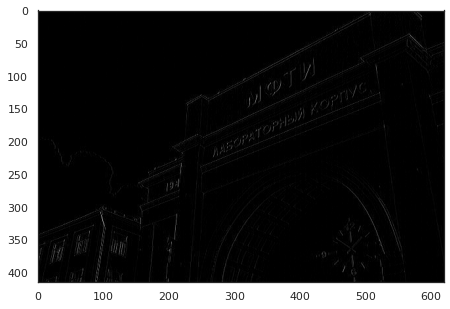

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[[ 0  1  0]
 [ 1 -4  1]
 [ 0  1  0]]



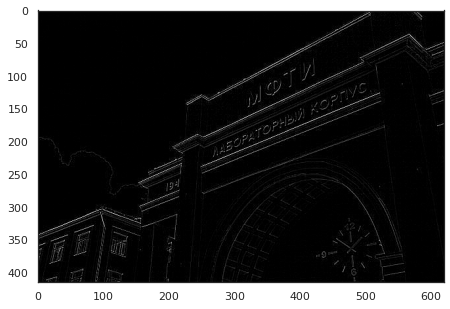

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]



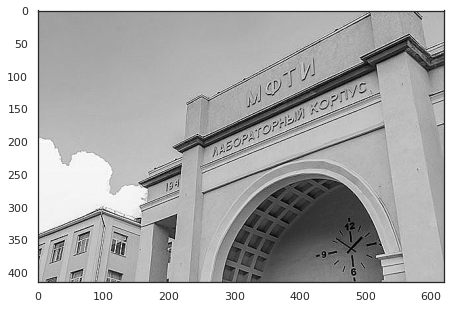


[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]



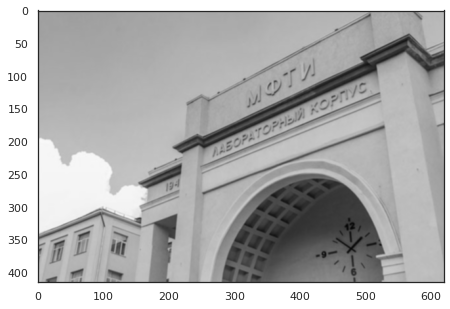

In [ ]:
plt.figure(figsize=(8, 5))
plt.imshow(RGB_img)
plt.show()

for filter in filters:
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    #kernel = torch.tensor([
    #    [0, 0, 0],
    #    [1, -2, 1],
    #    [0, 0, 0]
    #]).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = torch.tensor(filter).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #

    print('\n%s\n' % np.array(filter))

    plt.figure(figsize=(8, 5))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np);
    plt.show();

In [ ]:
#plt.figure(figsize=(8, 5))
#result_np = result.permute(1, 2, 0).numpy() / 256 / 3

#plt.imshow(result_np);
#plt.show();

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1. размытие - Е

$\begin{array}{ccc}
0.0625 & 0.125 & 0.0625\\
0.125 & 0.25 & 0.125\\
0.0625 & 0.125 & 0.0625
\end{array}$

2. увелечиние резкости - Д

$\begin{array}{ccc}
0 & -1 & 0\\
-1 & 5 & -1\\
0 & -1 & 0
\end{array}$

3. тождественное преобразование - А

$\begin{array}{ccc}
0 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0
\end{array}$

4. выделение вертикальных границ - В

$\begin{array}{ccc}
0 & 0 & 0\\
1 & -2 & 1\\
0 & 0 & 0
\end{array}$

5. выделение горизонтальных границ - Б

$\begin{array}{ccc}
0 & 1 & 0\\
0 & -2 & 0\\
0 & 1 & 0
\end{array}$

6. выделение границ - Г

$\begin{array}{ccc}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0
\end{array}$


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        #self.pool1 = #YOUR CODE
        #self.conv2 = #YOUR CODE
        #self.pool2 = #YOUR CODE
        #self.fc1 = #YOUR CODE  
        #self.fc2 = #YOUR CODE
        #self.fc3 = #YOUR CODE
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features= 5*5*16, out_features=120) 
        self.fc2 = nn.Linear(in_features=120 , out_features=84)
        self.fc3 = nn.Linear(in_features=84 , out_features=10)

        self.activation = F.relu

    def forward(self, x):
        #x = #YOUR CODE. Apply layers created in __init__. 
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool2(x)
        #print(x.shape)
        x = x.view(-1, 5*5*16)
        x = self.fc1(x)
        self.activation
        x = self.fc2(x)
        self.activation
        x = self.fc3(x)
        return x

исхордное изображение - 28х28х1

после 1-й свертки - 26х26х6

после пулинга - 13х13х6

после 2-й свертки - 11х11х16

после пулинга - 5х5х16

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device: ', device)

device:  cuda


In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
#<YOUR CODE>
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm_notebook(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm_notebook(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = correct = torch.sum(preds == y_batch)
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.9062666666666667


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9735


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9735333333333334


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9792


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9805666666666667


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9817


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9840166666666667


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9837


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9862833333333333


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9848


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.98745


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9846


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9882333333333333


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9841


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9891


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9838


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9899


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.983


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9903166666666666


  0%|          | 0/79 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9824


In [ ]:
#model.forward(torch.FloatTensor(next(iter(train_dataloader))[0]))

In [ ]:
lenet_accuracy = accuracy["valid"]
lenet_accuracy

[0.9735, 0.9792, 0.9817, 0.9837, 0.9848, 0.9846, 0.9841, 0.9838, 0.983, 0.9824]

Сравним с предыдущем пунктом

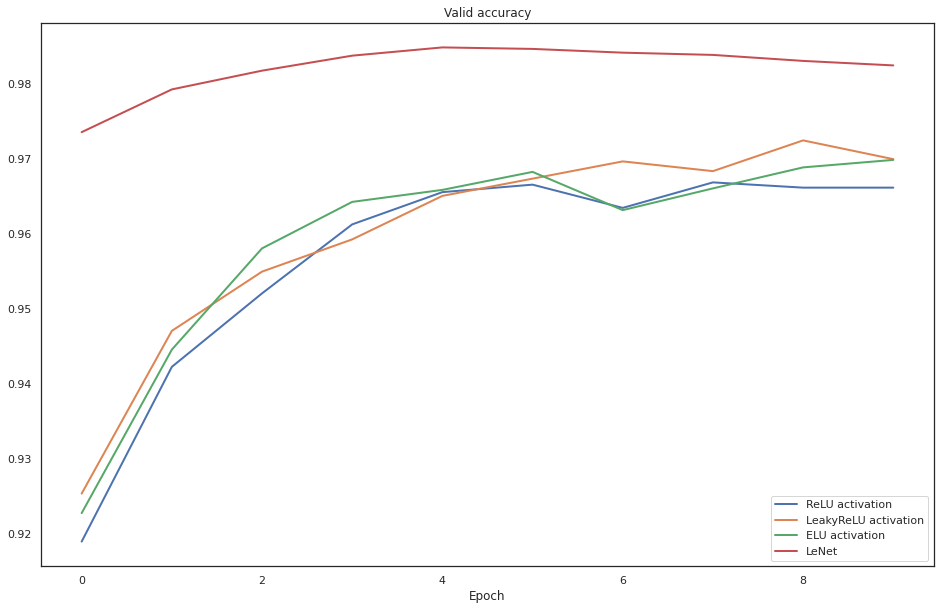

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

0.98